## ВКР: обработка данных

Автоматизация подбора персонала

Копчев Владислав, БПМИ197

#### Зачем этот ноутбук?

В `scraping.ipynb` были собраны и подготовлены данные. Возможно, стоит еще доработать (в разделе "пост-обработка"):
- Словарь образования
- Справочник по интересам
- Аналитические комбинации слов

Стоит убрать раздел "Черновик" оттуда и перенести сюда основные результаты.

Что сделать в ближайшее время?

1. Сегментацию разными правилами

2. Разметить текст и построить скоринговую (классификационную) модель

Для начала — разбиение на термы, оно было в Черновике.

### Библиотеки

selenium поскольку нужен js

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
# !pip install transliterate
from transliterate import translit
import re
import numpy as np

### Далее

Разметим первые 100 резюме:

In [2]:
df = pd.read_csv('backup/16.11/resumes_features.csv')
df.head(100)

,Unnamed: 0,Unnamed: 0.1,Ссылка,Название,Коммандировка,Опыт,О себе,Образование,Интересы,Навыки,...,Кол-во образований,Работа 1,Работа 2,Топовость образования,is_eng?,Справочник по интересам,Навыки списком,Релокация?,Коммандировка?,Город?
0,0,0,https://hh.ru/resume/1aa91e410000fd3cda0039ed1...,Analyst,"Moscow, willing to relocate, prepared for occa...",Work experience 7 years 4 months,"Responsible, communicable, quick study and det...",Higher education\n2015\nMOSCOW STATE UNIVERSIT...,"Specializations:\nSales manager, account manag...",Поддержка продаж / владение ПО для поддержки п...,...,1,"NUTRICIA\nMoscow, nutricia.ru\nFood Products.....","Volkswagen Group Russia\nMoscow, www.volkswage...",False,ENG,---,['Поддержка продаж / владение ПО для поддержки...,prepared for occasional business trips,willing to relocate,Moscow
1,1,1,https://hh.ru/resume/628596ac000657935b0039ed1...,BI аналитик,"Москва, не готова к переезду, готова к редким ...",Опыт работы 1 год 5 месяцев,В последние годы проходила обучение без возмож...,Высшее образование (Бакалавр)\n2022\nНациональ...,"Специализации:\nBI-аналитик, аналитик данных\n...","Работа с компьютерными программами, программы ...",...,1,"Ozon\nМладший аналитик\nСоздание, поддержка и ...",OZON\nСтажер группы BI аналитики и отчетности\...,True,RU,found smt by rule (Analyst)|(Аналитик данных)|...,"['Работа с компьютерными программами, программ...",готова к редким командировкам,не готова к переезду,Москва
2,2,2,https://hh.ru/resume/dfbcae000004342d8f0039ed1...,BI аналитик,"Москва, не готова к переезду, готова к команди...",Опыт работы 3 года 3 месяца,---,Высшее образование (Бакалавр)\n2019\nСамарский...,"Специализации:\nАналитик\nBI-аналитик, аналити...",Другое\nPython\nSQL\nУмение работать в коллект...,...,1,"Банк ВТБ (ПАО)\nМосква, www.vtbcareer.com\nФин...",---,False,RU,found smt by rule (Analyst)|(Аналитик данных)|...,"['Другое', 'Python', 'SQL', 'Умение работать в...",готова к командировкам,не готова к переезду,Москва
3,3,3,https://hh.ru/resume/bebf6a630008069d8c0039ed1...,Аналитик,"Санкт-Петербург, м. Гражданский проспект, гото...",Опыт работы 7 лет 2 месяца,Имею экономическое образование. Продвинутый по...,Высшее образование (Бакалавр)\n2015\nСанкт-Пет...,Специализации:\nАналитик\nЗанятость: полная за...,"Работа с компьютерными программами, программы ...",...,1,A&D Mortgage\nСтарший BI аналитик\nСоздание Po...,"Сбер\nСанкт-Петербург, rabota.sber.ru/\nФинанс...",False,RU,found smt by rule (Analyst)|(Аналитик данных)|...,"['Работа с компьютерными программами, программ...",готов к командировкам,готов к переезду,Санкт
4,4,4,https://hh.ru/resume/8606f37b000773de980039ed1...,Программист-разработчик,"Москва, м. Петровско-Разумовская, не готов к п...",Опыт работы 1 год 1 месяц,Имеется опыт в создании Android-приложений на ...,Высшее образование (Бакалавр)\n2022\nЧелябинск...,"Специализации:\nПрограммист, разработчик\nЗаня...",Применение стека технологий/Цифровые навыки\nL...,...,1,MoneyCare\nBI-аналитик\nРабота с big data(Pyth...,---,False,ENG,---,['Применение стека технологий/Цифровые навыки'...,не готов к командировкам,не готов к переезду,Москва
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,95,https://hh.ru/resume/ff6db1a000005dc60b0039ed1...,Analyst,"Moscow, metro station Kantemirovskaya, willing...",Work experience 14 years 3 months,Hardworking and well-organized specialist with...,Higher education\n2022\nЯндекс Практикум\nИнже...,"Specializations:\nTester\nSales manager, accou...","Управление отношениями с клиентами, деловая ко...",...,3,"John Deere Agricultural Holdings, Inc.\nwww.jo...",---,False,ENG,found smt by rule (Analyst)|(Аналитик данных)|...,"['Управление отношениями с клиентами, деловая ...",prepared for occasional business trips,willing to relocate,Moscow
96,96,96,https://hh.ru/resume/4a19a20e0002b43ffe0039ed1...,Аналитик-маркетолог,"Москва, м. Раменки, не готова к переезду, гото...",Опыт работы 3 года 7 месяцев,"Ответственна к выполн

Сделаю это в икселе в отдельном файле пр принципу 0-1-2 х2

**Итак, текст размечен для классификации. Теперь сегментация по "О себе".**

Токенизация раздела "О себе" на 1-граммы:

In [3]:
import nltk
# nltk.download('stopwords')

import re
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
patterns = "[0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()
def lemmatize(doc):
    # print(doc)
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru and morph.normal_forms(token)[0] not in stopwords_ru:  # ВОТ откуда там стоп-слвоа — В not in stopwords_ru -> normal(В) = в
            # print(token)
            token = token.strip()
            token = morph.normal_forms(token)[0]
            tokens.append(token)
    if len(tokens) > 2:
        return tokens
    return None

df2 = pd.DataFrame(df['О себе'])

for col_ind in df2.index:
    col = df2.iloc[col_ind]['О себе']
    if col:
        df2.iloc[col_ind]['О себе'] = lemmatize(str(col))
        #print(lemmatize(str(col)))
        
data = df2['О себе']

from collections import defaultdict
word_freq = defaultdict(int)
for tokens in data.iloc[:]:
    if tokens:
        for token in tokens:
            word_freq[token] += 1

In [4]:
df2.sample(3)

,О себе
1162,"[ready, to, work, in, a, support, group, group..."
8552,None
4675,"[компьютерный, навык, c, ms, sql, ms, outlook,..."


^ Стоп-слова убраны, все в нормальной форме => их не будет и дальше.

На 2-граммы:

In [5]:
from nltk.util import ngrams
from nltk import word_tokenize 

tokens2 = []

for x in df2['О себе']:
    if x is not None:
        bigrams = []
        for bg in list(ngrams(x, 2)):
            bigrams.append(' '.join(bg))
        tokens2.append(bigrams)
    else:
        tokens2.append(None)
        
df2['О себе 2'] = tokens2

In [6]:
df2.sample(3)

,О себе,О себе 2
15026,"[компьютерный, навык, продвинуть, пользователь...","[компьютерный навык, навык продвинуть, продвин..."
4117,"[год, месяц, жить, работать, сша, южный, карол...","[год месяц, месяц жить, жить работать, работат..."
14845,None,None


На 3-граммы:

In [7]:
from nltk.util import ngrams
from nltk import word_tokenize 

tokens3 = []

for x in df2['О себе']:
    if x is not None:
        trigrams = []
        for tg in list(ngrams(x, 3)):
            trigrams.append(' '.join(tg))
        tokens3.append(trigrams)
    else:
        tokens3.append(None)
        
df2['О себе 3'] = tokens3

In [8]:
df2.sample(3)

,О себе,О себе 2,О себе 3
10194,"[иметь, успешный, опыт, работа, сфера, продажа...","[иметь успешный, успешный опыт, опыт работа, р...","[иметь успешный опыт, успешный опыт работа, оп..."
281,"[as, a, person, i, am, responsible, industriou...","[as a, a person, person i, i am, am responsibl...","[as a person, a person i, person i am, i am re..."
19357,"[taxation, tax, legislation, value, added, tax...","[taxation tax, tax legislation, legislation va...","[taxation tax legislation, tax legislation val..."


Строим эмбеддинги:

In [9]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

Избавились от пропусков:

In [10]:
df2.loc[df2['О себе 3'].isna(), 'О себе 3'] = '-'

In [11]:
df2[df2['О себе 3'].isna()]['О себе 3']

Series([], Name: О себе 3, dtype: object)

In [12]:
model = Word2Vec(sentences=df2['О себе 3'], vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

In [13]:
model = Word2Vec.load("word2vec.model")

In [14]:
model

In [15]:
model.train(df2['О себе 3'], total_examples=len(df2['О себе 3']), epochs=1)

(955998, 956134)

^ наверное лучше еще привести все токены в тексте к норм. форме?

In [16]:
df2['О себе 3']

0        [responsible communicable quick, communicable ...
1        [последний год проходить, год проходить обучен...
2                                                        -
3        [иметь экономический образование, экономически...
4        [иметься опыт создание, опыт создание android,...
                               ...                        
19813    [высокий работоспособность вдумчивость, работо...
19814    [увлекаться спорт вредный, спорт вредный привы...
19815    [уверенный пользователь пк, пользователь пк ра...
19816    [абсолютно честный очень, честный очень ответс...
19817    [i общий подготовленность, общий подготовленно...
Name: О себе 3, Length: 19818, dtype: object

In [17]:
vector = model.wv['последний год проходить']  # get numpy vector of a word
sims = model.wv.most_similar('последний год проходить', topn=10)  # get other similar words

In [18]:
sims

[('проходить обучение возможность', 0.9960277676582336),
 ('обучение возможность работать', 0.9956817626953125),
 ('год проходить обучение', 0.9881961941719055),
 ('возможность работать проходить', 0.9176284670829773),
 ('возможность работать заниматься', 0.9058912396430969),
 ('проходить обучение университет', 0.8709518909454346),
 ('привычка последний год', 0.8586905598640442),
 ('год проходить служба', 0.8362846374511719),
 ('возможность работать специальность', 0.8184468746185303),
 ('трудолюбивый последний год', 0.8159952163696289)]

In [19]:
vector

array([-0.38224608, -0.10416935, -0.29327798, -0.24197203, -0.21096751,
       -0.05376937, -0.00557683, -0.05706993,  0.27308747,  0.10972447,
       -0.58219266,  0.09858397,  0.35054368, -0.24991637, -0.0691798 ,
       -0.38631028, -0.11197734, -0.07669573, -0.20271152,  0.00702736,
        0.31110033,  0.3403267 ,  0.0491253 , -0.1403182 ,  0.4324605 ,
       -0.18446556,  0.5500054 ,  0.1370261 , -0.400346  , -0.16686279,
       -0.08281644,  0.03532175,  0.09530672, -0.34281516,  0.08460419,
        0.07416123, -0.2718026 ,  0.17034136, -0.01276292,  0.0086637 ,
       -0.09886485,  0.31546336, -0.13489509, -0.49652508, -0.09334091,
       -0.08579285,  0.0391993 , -0.09498197,  0.12627424, -0.22235146,
        0.63042635, -0.3121707 , -0.23802307, -0.00582073,  0.01436302,
        0.08701384, -0.01479471, -0.3520302 , -0.35258174,  0.06406838,
       -0.09708417,  0.03958943, -0.3674414 , -0.12208879, -0.04377769,
       -0.14439434, -0.58502644,  0.06897984, -0.18484744,  0.43

Итак, мы построили эмбеддинги. Теперь кластеризуем. Для этого сначала строим новую табличку:

In [20]:
model.wv

In [21]:
our_data = pd.DataFrame(df2['О себе 3'])

In [22]:
our_data['emb'] = 0

In [23]:
our_data

,О себе 3,emb
0,"[responsible communicable quick, communicable ...",0
1,"[последний год проходить, год проходить обучен...",0
2,-,0
3,"[иметь экономический образование, экономически...",0
4,"[иметься опыт создание, опыт создание android,...",0
...,...,...
19813,"[высокий работоспособность вдумчивость, работо...",0
19814,"[увлекаться спорт вредный, спорт вредный привы...",0
19815,"[уверенный пользователь пк, пользователь пк ра...",0
19816,"[абсолютно честный очень, честный очень ответс...",0


In [24]:
embs = []
for x in our_data['О себе 3']:
    cur_embs = []
    for y in x:
        cur_embs.append(model.wv[y])
    embs.append(cur_embs)

In [25]:
our_data['emb'] = embs

In [26]:
embs_flattened = []
for x in our_data['emb']:
    x_flat = []
    for z in x:
        x_flat += list(z)
    embs_flattened.append(x_flat)

In [27]:
our_data['flat_emb'] = embs_flattened

в чем проблема с `flat_emb` как эмбеддингами??? именно поэтому не работает kmeans.

Итак, у меня для каждого токена в тексте есть эмбеддинг. Как из этого получить что-то адекватное?

In [28]:
our_data['flat_emb'][0]

[0.0051613357,
 0.0030811299,
 0.00021986982,
 0.0062657,
 0.010089291,
 -0.006166162,
 -0.006073247,
 0.0039943247,
 0.0002663877,
 0.005464185,
 0.0016145807,
 -0.0018485739,
 0.006251343,
 0.008865231,
 -0.0008676488,
 -0.009875481,
 -0.007519612,
 -0.001008593,
 0.009041765,
 -0.009653698,
 -0.009491646,
 0.001626272,
 0.003788767,
 -0.008040229,
 0.005559785,
 0.0014249026,
 -0.0033184418,
 0.0034322392,
 0.009485477,
 0.001564891,
 0.0012084979,
 -0.005850873,
 -0.006636588,
 0.007894108,
 -0.0028310518,
 0.00011636821,
 0.0060656522,
 -0.0026826782,
 -0.008022264,
 0.009723766,
 -0.007193995,
 -0.0035857977,
 -0.0075545874,
 -0.0006639098,
 0.00025431666,
 0.0063885264,
 0.0018332643,
 0.00049191294,
 -0.0017750579,
 0.00077007234,
 -0.0029705537,
 0.006847732,
 0.0054421336,
 -0.002827773,
 0.00063634955,
 0.002282429,
 0.005730041,
 -0.00043247937,
 0.0014314917,
 -0.007157394,
 0.0062590195,
 -0.0035431003,
 -0.006121296,
 0.001450516,
 -0.0081871515,
 0.0017620497,
 -0.00136

In [29]:
our_data['flat_emb'].dropna()

0        [0.0051613357, 0.0030811299, 0.00021986982, 0....
1        [-0.38224608, -0.104169354, -0.29327798, -0.24...
2        [-0.00053622725, 0.00023643016, 0.0051033497, ...
3        [-0.0036759318, -0.0043020877, 0.0036185668, -...
4        [-0.0060206014, -0.0033397267, 0.0065526096, -...
                               ...                        
19813    [-0.0032745143, 0.005141565, -0.005992916, -0....
19814    [-0.0059840814, -0.009909181, 0.0012707736, -0...
19815    [0.618497, 1.1197418, -0.24599522, 0.04932119,...
19816    [-0.0052393475, 0.0028257044, 0.004790728, 0.0...
19817    [-6.759283e-05, 0.003551336, 0.00357902, 0.004...
Name: flat_emb, Length: 19818, dtype: object

In [44]:
our_data['flat_emb'] * 2

0        [0.0051613357, 0.0030811299, 0.00021986982, 0....
1        [-0.38224608, -0.104169354, -0.29327798, -0.24...
2        [-0.00053622725, 0.00023643016, 0.0051033497, ...
3        [-0.0036759318, -0.0043020877, 0.0036185668, -...
4        [-0.0060206014, -0.0033397267, 0.0065526096, -...
                               ...                        
19813    [-0.0032745143, 0.005141565, -0.005992916, -0....
19814    [-0.0059840814, -0.009909181, 0.0012707736, -0...
19815    [0.618497, 1.1197418, -0.24599522, 0.04932119,...
19816    [-0.0052393475, 0.0028257044, 0.004790728, 0.0...
19817    [-6.759283e-05, 0.003551336, 0.00357902, 0.004...
Name: flat_emb, Length: 19818, dtype: object

In [46]:
our_data['flat_emb']

0        [0.0051613357, 0.0030811299, 0.00021986982, 0....
1        [-0.38224608, -0.104169354, -0.29327798, -0.24...
2        [-0.00053622725, 0.00023643016, 0.0051033497, ...
3        [-0.0036759318, -0.0043020877, 0.0036185668, -...
4        [-0.0060206014, -0.0033397267, 0.0065526096, -...
                               ...                        
19813    [-0.0032745143, 0.005141565, -0.005992916, -0....
19814    [-0.0059840814, -0.009909181, 0.0012707736, -0...
19815    [0.618497, 1.1197418, -0.24599522, 0.04932119,...
19816    [-0.0052393475, 0.0028257044, 0.004790728, 0.0...
19817    [-6.759283e-05, 0.003551336, 0.00357902, 0.004...
Name: flat_emb, Length: 19818, dtype: object

In [70]:
X = list(our_data['flat_emb'].dropna())

In [74]:
X = np.asarray(X)

In [73]:
for x in X:

/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


array([list([0.0051613357, 0.0030811299, 0.00021986982, 0.0062657, 0.010089291, -0.006166162, -0.006073247, 0.0039943247, 0.0002663877, 0.005464185, 0.0016145807, -0.0018485739, 0.006251343, 0.008865231, -0.0008676488, -0.009875481, -0.007519612, -0.001008593, 0.009041765, -0.009653698, -0.009491646, 0.001626272, 0.003788767, -0.008040229, 0.005559785, 0.0014249026, -0.0033184418, 0.0034322392, 0.009485477, 0.001564891, 0.0012084979, -0.005850873, -0.006636588, 0.007894108, -0.0028310518, 0.00011636821, 0.0060656522, -0.0026826782, -0.008022264, 0.009723766, -0.007193995, -0.0035857977, -0.0075545874, -0.0006639098, 0.00025431666, 0.0063885264, 0.0018332643, 0.00049191294, -0.0017750579, 0.00077007234, -0.0029705537, 0.006847732, 0.0054421336, -0.002827773, 0.00063634955, 0.002282429, 0.005730041, -0.00043247937, 0.0014314917, -0.007157394, 0.0062590195, -0.0035431003, -0.006121296, 0.001450516, -0.0081871515, 0.0017620497, -0.0013645526, -0.0027159217, 0.0036084547, -0.0009240845, -0.

In [79]:
X = np.array([np.array([1, 2, 3]), np.array([2, 3, 4]), np.array([5, 6, 7])])

In [85]:
embs_flattened[0]

[0.0051613357,
 0.0030811299,
 0.00021986982,
 0.0062657,
 0.010089291,
 -0.006166162,
 -0.006073247,
 0.0039943247,
 0.0002663877,
 0.005464185,
 0.0016145807,
 -0.0018485739,
 0.006251343,
 0.008865231,
 -0.0008676488,
 -0.009875481,
 -0.007519612,
 -0.001008593,
 0.009041765,
 -0.009653698,
 -0.009491646,
 0.001626272,
 0.003788767,
 -0.008040229,
 0.005559785,
 0.0014249026,
 -0.0033184418,
 0.0034322392,
 0.009485477,
 0.001564891,
 0.0012084979,
 -0.005850873,
 -0.006636588,
 0.007894108,
 -0.0028310518,
 0.00011636821,
 0.0060656522,
 -0.0026826782,
 -0.008022264,
 0.009723766,
 -0.007193995,
 -0.0035857977,
 -0.0075545874,
 -0.0006639098,
 0.00025431666,
 0.0063885264,
 0.0018332643,
 0.00049191294,
 -0.0017750579,
 0.00077007234,
 -0.0029705537,
 0.006847732,
 0.0054421336,
 -0.002827773,
 0.00063634955,
 0.002282429,
 0.005730041,
 -0.00043247937,
 0.0014314917,
 -0.007157394,
 0.0062590195,
 -0.0035431003,
 -0.006121296,
 0.001450516,
 -0.0081871515,
 0.0017620497,
 -0.00136

In [90]:
len(embs_flattened[0])

500

In [96]:
X = embs_flattened

In [109]:
for x in our_data['emb'][0]:
    print(len(x))

100
100
100
100
100


Кластеризуем:

In [97]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

kmeans = KMeans(
                init="random",
                n_clusters=3,
                n_init=10,
                max_iter=300,
                random_state=42
            )

kmeans.fit(X)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (19818,) + inhomogeneous part.

In [100]:
for x in embs_flattened:
    print(len(x))

500
4000
100
3200
6800
8500
100
5300
1800
1200
1200
12700
9100
1000
12600
100
800
1200
100
100
10300
800
15000
5400
3600
100
5900
7000
2800
5400
7600
7600
100
3500
2900
11400
2000
3300
13700
2100
1200
11700
5600
2500
100
100
1400
5000
3000
3200
100
3600
6200
6100
3100
6600
6300
5200
900
100
29000
3700
100
100
1800
1500
13400
100
17700
400
1400
17100
3300
12400
2800
2800
3500
400
100
4000
5700
3800
100
800
300
5800
100
13000
3500
3100
100
4700
14800
100
100
3700
3300
1100
4200
1400
3300
2100
1600
3500
17900
100
600
9200
5700
5000
100
10700
3800
1000
800
8200
100
1400
7900
500
7800
100
1400
1200
2000
11200
9200
14400
3800
100
3200
100
100
400
7900
100
1800
1400
500
3200
100
6400
2200
1000
700
100
900
4100
1500
100
2800
7100
16500
3300
100
7000
1700
2400
1900
100
6100
4800
12200
8900
900
3900
2900
4300
3700
100
8200
2000
3400
300
10000
100
12500
2900
400
1600
1800
8100
100
4200
1300
4000
18400
7400
4000
100
21200
1500
2200
5900
6800
9500
5400
6300
4000
2000
1200
3600
900
7600
1300
100
100

Почитать:

Тоже уменьшить как-то размер ноутбука

### Черновик (раньше был в `scraping.ipynb`)

embeddings:

- tf-idf: важность слов (вектор = мера важности каждого слова в документе через запятую)

- word2vec и BERT: учиытвают семантические особенности

Курс по тектсовой аналитике с Я.Диска + 

https://stepik.org/course/129443/promo пока не смотрел

см еще статьи в папке 7.12

Реализация w2v https://towardsdatascience.com/a-word2vec-implementation-using-numpy-and-python-d256cf0e5f28

lib: https://radimrehurek.com/gensim/models/word2vec.html (потом пойму в чем ограничения)

In [167]:
from collections import defaultdict
word_freq = defaultdict(int)
for tokens in data.iloc[:]:
    if tokens:
        for token in tokens:
            word_freq[token] += 1

In [169]:
len(word_freq)
sorted(word_freq, key=word_freq.get, reverse=True)[:50]

['работа',
 '•',
 'опыт',
 'знание',
 'навык',
 'работать',
 'бизнес',
 'умение',
 'проект',
 'управление',
 'система',
 'разработка',
 'ms',
 'год',
 'компания',
 'команда',
 'продажа',
 'анализ',
 'процесс',
 'результат',
 'качество',
 'решение',
 'пользователь',
 'ответственность',
 'задача',
 'новый',
 'уровень',
 'высокий',
 'язык',
 'дать',
 'аналитический',
 'способность',
 'excel',
 'иметь',
 'office',
 'личный',
 'организация',
 'развитие',
 'человек',
 'программа',
 'финансовый',
 'профессиональный',
 'коммуникабельность',
 'обучение',
 '–',
 'sql',
 'клиент',
 'уметь',
 'microsoft',
 'c']

In [174]:
from collections import defaultdict
word_freq = defaultdict(int)
for tokens in data2.iloc[:]:
    if tokens:
        for token in tokens:
            word_freq[token] += 1

In [175]:
df2.sample(3)

,О себе,О себе 2
8772,"[английский, язык, –, средний, уровень, уверен...","[английский язык, язык –, – средний, средний у..."
2891,None,None
4710,"[•, коммуникабельность, ответственность, добро...","[• коммуникабельность, коммуникабельность отве..."


In [176]:
len(word_freq)
sorted(word_freq, key=word_freq.get, reverse=True)[:50]

['опыт работа',
 'умение работать',
 'бизнес процесс',
 'ms office',
 'работать команда',
 'личный качество',
 'склад ум',
 'аналитический склад',
 'уверенный пользователь',
 'пользователь пк',
 'английский язык',
 'word excel',
 'нацеленность результат',
 'больший объём',
 'вредный привычка',
 'microsoft office',
 'управление проект',
 'опытный пользователь',
 'большой опыт',
 'база дать',
 'иметь опыт',
 '• опыт',
 'объём информация',
 'навык работа',
 'ведение переговоры',
 'жизненный позиция',
 'высокий работоспособность',
 'power point',
 'право категория',
 'активный жизненный',
 'высокий уровень',
 'быстрый обучаемость',
 'уметь работать',
 'организаторский способность',
 'поставить задача',
 'информационный система',
 'принимать решение',
 'работать больший',
 'продвинуть пользователь',
 'легко обучать',
 'водительский право',
 'опыт управление',
 '• знание',
 'аналитический способность',
 'office word',
 'ms sql',
 'профессиональный навык',
 'режим многозадачность',
 'программ

**хм t-SNE**:

сделаю как тут https://towardsdatascience.com/using-word2vec-to-analyze-news-headlines-and-predict-article-success-cdeda5f14751

In [68]:
pd.DataFrame(dict(model.wv.key_to_index).values(), index=dict(model.wv.key_to_index).keys())

,0
и,0
в,1
на,2
с,3
опыт,4
...,...
остальных,308
программ,309
MS,310
"Office,",311


In [69]:
d=dict()

In [70]:
for x in model.wv.key_to_index:
    d[x] = model.wv[x]

In [76]:
df = pd.DataFrame(d.values(), index=d.keys())

In [77]:
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(df[:400])

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

In [83]:
#!pip install adjustText

  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7098 sha256=a8b3d0dea7f763da414ae68eab29e13f0455d5c8e8d2ab3803f923aade46551e
  Stored in directory: /Users/vladkopchev/Library/Caches/pip/wheels/6b/1d/79/4326d5f3a7d86fb9900e5564e7a0f98b552da5103ca762f24f
Successfully built adjustText


In [87]:
tsne_df0 = tsne_df
tsne_df = tsne_df[:10]

/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


IndexError: index 10 is out of bounds for axis 0 with size 10

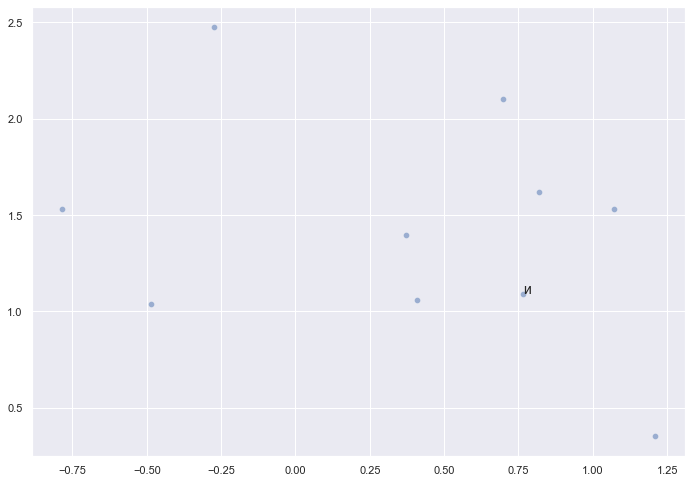

In [88]:
sns.set()
# Initialize figure
fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Import adjustText, initialize list of texts
from adjustText import adjust_text
texts = []
words_to_plot = list(np.arange(0, 400, 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df.index[word], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

NameError: name 'main_data' is not defined

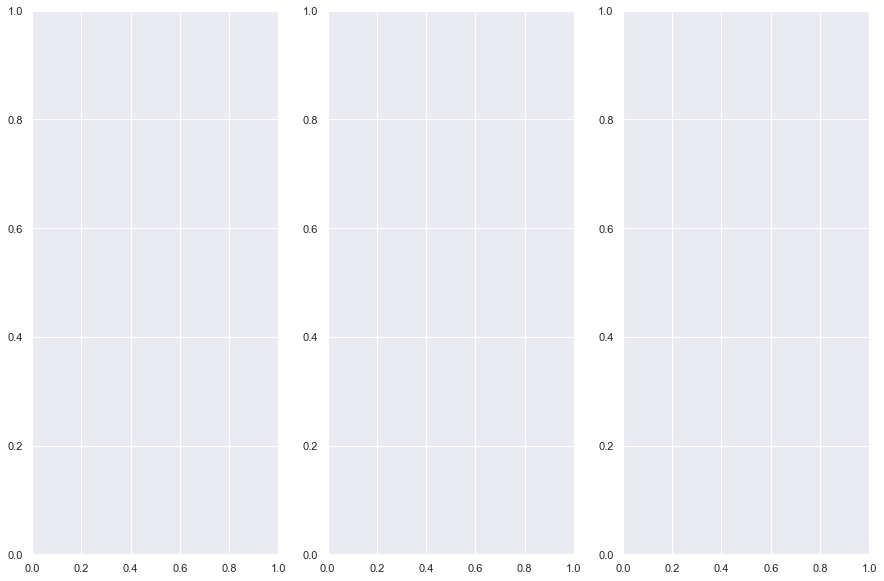

In [89]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))

subplots = [a for a in ax]
platforms = ['Facebook', 'GooglePlus', 'LinkedIn']
colors = list(sns.husl_palette(10, h=.5)[1:4]) 

for platform, subplot, color in zip(platforms, subplots, colors):
    sns.scatterplot(x = main_data[platform], y = main_data['SentimentTitle'], ax=subplot, color=color)
    subplot.set_title(platform, fontsize=18)
    subplot.set_xlabel('') 
    
fig.suptitle('Plot of Popularity (Shares) by Title Sentiment', fontsize=24)

plt.show()

**кластерный анализ**

Итог:
1. Написано что-то про сбор данных и обработку (извлечение сущностей)
2. Начат анализ ланных (предобработка, токенизация в т. ч. на биграммы)
3. Теперь смотрим кластерный анализ (KMeans, Tri-Culster, EM-алгоритм)

Покажу это (все пункты), начало презы -> буду оформлять код получше... Уже много всего надо оформить.

стр. 21; После сегментации будут топики и текстовая аналитика

У нас есть три (см. звонок) важные штуки (позиция, условия труда, специализация) — $X, Y, Z$. 
$(V, W, U)$ s. t. $V \in X, W \in Y, U \in Z$ — то есть, это какие-то элементы наших массивов-столбцов. Вводим переменную $Diff(i)$ со сложной формулой. Для интуиции почитаю ту статью. 

В общем, надо будет весь этот ужас реализовать... Алгоритм 1.

Пока разбираю статью про triclustering.

n-ary relations among several sets of entities

– job banks comprising at least four sets (jobs, job descriptions, job seekers,

это оно!

Про EM-алгоритм: https://habr.com/ru/post/501562/

Про трикластер еще см прещу ту для интерпретации, а дальше разберусь с описанием алгоритма.

Черновик имплементации алгоритма:

1. Мы работаем тут с матрицей. Поэтому построю отображение $r_{i, j, k} = 0/1$. См пример output'а из того ноутбука: вполне адекватно.

Как потом эти три-кластеры интерпретировать? Что если взять объекты из $V, W, U$ любая тройка оттуда будет задавать одно и то же отношение?

**Спросить во время звонка:**

- Презентация

- Project Proposal

- Кластеризация методы